In [8]:
# 1) Patient-level aggregation: compute per-patient / per-timepoint features and save CSV
import pandas as pd
import numpy as np
from scipy.stats import entropy
from pathlib import Path
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

output_dir = Path('../Processed_Data')
output_dir.mkdir(parents=True, exist_ok=True)

# Ensure `adata` is available (load processed file if not in memory)
if 'adata' not in globals():
    processed_path = Path('../Processed_Data/processed_s_rna_seq_data.h5ad')
    if processed_path.exists():
        print(f'Loading processed AnnData from {processed_path}')
        adata = sc.read_h5ad(processed_path)
    else:
        raise FileNotFoundError('`adata` not in memory and processed file not found.')

# Identify patient and timepoint columns
patient_col = 'patient_id' if 'patient_id' in adata.obs.columns else ('patient' if 'patient' in adata.obs.columns else None)
timepoint_col = 'timepoint' if 'timepoint' in adata.obs.columns else ('sample_id' if 'sample_id' in adata.obs.columns else None)
if patient_col is None:
    raise RuntimeError('No patient identifier column found in adata.obs (expected `patient_id` or `patient`).')

# Prefer TRB clonotypes, fallback to TRA or generic clone id
clone_col = None
for c in ['cdr3_TRB','cdr3_TRA','clone_id','clonotype']:
    if c in adata.obs.columns:
        clone_col = c
        break

# Helper diversity functions
def simpson_index(counts):
    counts = np.asarray(counts)
    if counts.sum() == 0:
        return np.nan
    p = counts / counts.sum()
    return float((p ** 2).sum())

def gini_coefficient(counts):
    x = np.asarray(counts, dtype=float)
    if x.size == 0 or x.sum() == 0:
        return np.nan
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return float((2.0 * np.sum(index * x)) / (n * x.sum()) - (n + 1) / n)

# Heuristic cluster columns to produce cluster fractions
cluster_columns = [c for c in adata.obs.columns if ('cluster' in c.lower() or c.endswith('_clusters') or c == 'gene_expression_modules')]
if not cluster_columns:
    cluster_columns = [c for c in adata.obs.columns if pd.api.types.is_categorical_dtype(adata.obs[c]) and 2 <= adata.obs[c].nunique() <= 50]
cluster_columns = list(dict.fromkeys(cluster_columns))

group_cols = [patient_col] + ([timepoint_col] if timepoint_col is not None else [])
grp = adata.obs.groupby(group_cols)

records = []
for name, df in grp:
    rec = {}
    if isinstance(name, tuple):
        rec['patient_id'] = name[0]
        if timepoint_col is not None:
            rec['timepoint'] = name[1]
    else:
        rec['patient_id'] = name
        if timepoint_col is not None:
            rec['timepoint'] = ''
    rec['n_cells'] = int(df.shape[0])
    # sample/patient-level response if present
    if 'response' in df.columns:
        try:
            rec['response'] = str(df['response'].mode().iloc[0])
        except Exception:
            rec['response'] = ''
    else:
        rec['response'] = ''

    # clonotype metrics
    if clone_col is not None:
        clones = df[clone_col].dropna().astype(str)
        if len(clones) > 0:
            vc = clones.value_counts()
            counts = vc.values
            rec['n_unique_clones'] = int(vc.size)
            # Shannon (entropy), Simpson, Gini (clonality metrics)
            rec['shannon_diversity'] = float(entropy(counts / counts.sum()))
            rec['simpson_index'] = float(simpson_index(counts))
            rec['gini_clonality'] = float(gini_coefficient(counts))
            # top clonotypes
            top = vc.head(5)
            total = counts.sum() if counts.sum() > 0 else 1
            for i, (cl, v) in enumerate(top.items(), start=1):
                rec[f'top_clonotype_{i}_seq'] = cl
                rec[f'top_clonotype_{i}_count'] = int(v)
                rec[f'top_clonotype_{i}_frac'] = float(v / total)
            rec['frac_top1'] = float(top.iloc[0] / total) if len(top) > 0 else 0.0
            rec['frac_top5'] = float(top.sum() / total) if len(top) > 0 else 0.0
        else:
            rec['n_unique_clones'] = 0
            rec['shannon_diversity'] = np.nan
            rec['simpson_index'] = np.nan
            rec['gini_clonality'] = np.nan
            rec['frac_top1'] = np.nan
            rec['frac_top5'] = np.nan
    else:
        rec['n_unique_clones'] = np.nan
        rec['shannon_diversity'] = np.nan
        rec['simpson_index'] = np.nan
        rec['gini_clonality'] = np.nan
        rec['frac_top1'] = np.nan
        rec['frac_top5'] = np.nan

    # mean physicochemical properties (if encoded)
    phys_cols = [c for c in adata.obs.columns if c.startswith('tra_') or c.startswith('trb_')]
    for pc in phys_cols:
        rec[f'mean_{pc}'] = float(df[pc].dropna().mean()) if pc in df.columns else np.nan

    # cluster fractions + cluster entropy
    for ccol in cluster_columns:
        vc = df[ccol].value_counts(normalize=True)
        for label, frac in vc.items():
            rec[f'frac_{ccol}_{label}'] = float(frac)
        rec[f'{ccol}_entropy'] = float(entropy(vc.values)) if len(vc) > 0 else np.nan

    records.append(rec)

patient_df = pd.DataFrame(records).fillna(np.nan)
out_path = output_dir / 'patient_level_features.csv'
patient_df.to_csv(out_path, index=False)
print(f'Saved patient-level features to {out_path}')
patient_df.head()


Saved patient-level features to ..\Processed_Data\patient_level_features.csv


,patient_id,timepoint,n_cells,response,n_unique_clones,shannon_diversity,simpson_index,gini_clonality,top_clonotype_1_seq,top_clonotype_1_count,...,frac_leiden_integrated_14,frac_leiden_integrated_16,frac_leiden_integrated_19,frac_leiden_integrated_18,frac_leiden_integrated_21,frac_leiden_integrated_24,frac_leiden_integrated_23,frac_leiden_integrated_22,frac_leiden_integrated_20,leiden_integrated_entropy
0,PT1,Baseline,4008,Responder,3524,8.066620,0.000550,0.083556,CATSREGISGANVLTF,50,...,0.013473,0.011727,0.007236,0.005739,0.003244,0.000749,0.000749,0.000499,0.0,2.600359
1,PT1,Post-Chemo,3855,Responder,3133,7.869510,0.000833,0.144393,CASSEEGRATDTQYF,51,...,0.014527,0.019196,0.008301,0.014267,0.001297,0.000778,0.000259,0.012192,0.0,2.644746
2,PT2,Baseline,3127,Non-Responder,2748,7.853918,0.000528,0.071568,CASSGGNQPQHF,32,...,0.015350,0.019508,0.004157,0.008954,0.002558,0.000640,0.001919,0.000640,0.0,2.512519
3,PT2,Post-Chemo,2471,Non-Responder,1975,7.354026,0.001772,0.153540,CASSLGHYGYTF,71,...,0.011736,0.023472,0.010522,0.006475,0.002428,0.000000,0.003238,0.000000,0.0,2.648230
4,PT3,Baseline,915,Responder,844,6.707935,0.001325,0.043208,CSARDRTGNGYTF,9,...,0.009836,0.015301,0.006557,0.005464,0.001093,0.000000,0.001093,0.000000,0.0,2.429956


Saved GroupKFold results to Processed_Data/patient_level_groupcv_results.csv
Saved trained model to Processed_Data/patient_level_model_groupcv.joblib


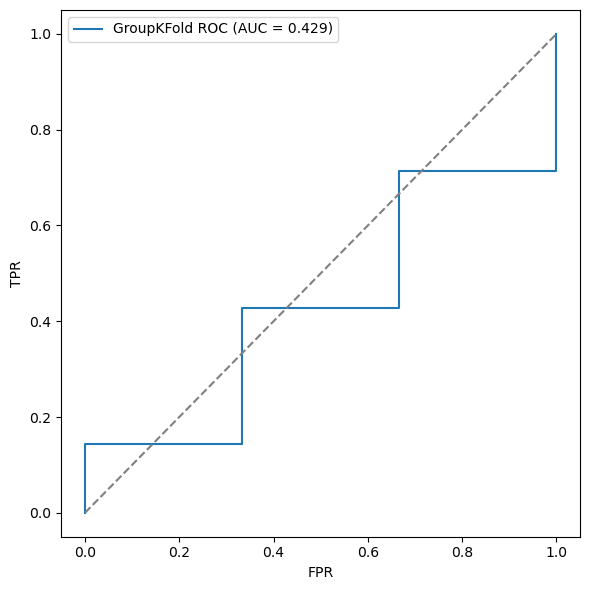

Saved ROC to Processed_Data/patient_level_groupcv_roc.png


In [9]:
# 2) Grouped CV supervised pipeline (patient-level folds using GroupKFold)
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from joblib import dump
import matplotlib.pyplot as plt

pf = Path('../Processed_Data/patient_level_features.csv')
if not pf.exists():
    raise FileNotFoundError('Run the patient-level aggregation cell first (patient_level_features.csv not found).')
patient_df = pd.read_csv(pf)
# require a response column with values like 'Responder' / 'Non-Responder'
if 'response' not in patient_df.columns or patient_df['response'].isnull().all():
    raise RuntimeError('`response` column not present in patient-level table. Ensure patient-level aggregation included response.')
# binary label (1: Responder, 0: Non-Responder/Other)
patient_df['label'] = (patient_df['response'] == 'Responder').astype(int)
# groups are patient_id (multiple timepoints per patient allowed)
groups = patient_df['patient_id']
# features: numeric columns only (drop identifiers and response)
drop_cols = ['patient_id','timepoint','response','label']
num_cols = patient_df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c not in drop_cols]
if len(feature_cols) == 0:
    raise RuntimeError('No numeric features found in patient-level table. Check that patient aggregation produced numeric features.')
X = patient_df[feature_cols].fillna(0)
y = patient_df['label']

n_groups = len(groups.unique())
if n_groups < 2:
    raise RuntimeError(f'Need at least 2 patients for GroupKFold; found {n_groups}')
n_splits = min(5, n_groups)
gkf = GroupKFold(n_splits=n_splits)
metrics = []
all_y_true = []
all_y_score = []
fold = 0
for train_idx, test_idx in gkf.split(X, y, groups):
    fold += 1
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    try:
        auc_score = roc_auc_score(y_test, y_score)
    except Exception:
        auc_score = float('nan')
    # Ensure confusion matrix is 2x2 even if one class is missing in y_test
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    metrics.append({'fold': fold, 'auc': float(auc_score), 'sensitivity': float(sens), 'specificity': float(spec)})
    all_y_true.extend(y_test.tolist())
    all_y_score.extend(y_score.tolist())

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('../Processed_Data/patient_level_groupcv_results.csv', index=False)
print('Saved GroupKFold results to Processed_Data/patient_level_groupcv_results.csv')
# train final model on all data and save
scaler = StandardScaler()
X_all = scaler.fit_transform(X)
clf_full = RandomForestClassifier(n_estimators=200, random_state=42)
clf_full.fit(X_all, y)
dump({'scaler': scaler, 'model': clf_full}, '../Processed_Data/patient_level_model_groupcv.joblib')
print('Saved trained model to Processed_Data/patient_level_model_groupcv.joblib')
# patient-level ROC curve (aggregated across folds)
from sklearn.metrics import roc_curve, auc
if len(set(all_y_true)) > 1:
    fpr, tpr, _ = roc_curve(all_y_true, all_y_score)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'GroupKFold ROC (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'--',color='grey')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()
    plt.tight_layout()
    plt.savefig('../Processed_Data/patient_level_groupcv_roc.png')
    plt.show()
    print('Saved ROC to Processed_Data/patient_level_groupcv_roc.png')
else:
    print('Not enough positive/negative samples across folds to compute ROC curve')


In [10]:
# 3) Pseudobulk differential expression + gene-set scoring (interferon/complement)
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

output_dir = Path('../Processed_Data')
output_dir.mkdir(parents=True, exist_ok=True)

# Ensure adata is available
if 'adata' not in globals():
    processed_path = Path('../Processed_Data/processed_s_rna_seq_data.h5ad')
    if processed_path.exists():
        adata = sc.read_h5ad(processed_path)
    else:
        raise FileNotFoundError('`adata` not found; run preprocessing first or provide processed_h5ad file.')

# Build pseudobulk sample labels (prefer sample_id; fallback to patient_id::timepoint)
if 'sample_id' in adata.obs.columns:
    sample_labels = adata.obs['sample_id'].astype(str)
else:
    tp = adata.obs['timepoint'].astype(str) if 'timepoint' in adata.obs.columns else ''
    sample_labels = adata.obs['patient_id'].astype(str) + '::' + tp

# Use adata.raw if available for counts else adata
adata_counts = adata.raw if getattr(adata, 'raw', None) is not None else adata
X = adata_counts.X
genes = list(adata_counts.var_names)
import scipy.sparse as sp

# Sum counts per sample
pseudobulk = []
samples = sample_labels.unique()
for s in samples:
    mask = (sample_labels == s).values
    sub = X[mask]
    if sp.issparse(sub):
        summed = np.asarray(sub.sum(axis=0)).ravel()
    else:
        summed = np.sum(sub, axis=0)
    pseudobulk.append(summed)
pseudobulk_counts = pd.DataFrame(np.vstack(pseudobulk).T, index=genes, columns=samples)
pseudobulk_counts.to_csv(output_dir / 'pseudobulk_counts.csv')
print('Saved pseudobulk counts to', output_dir / 'pseudobulk_counts.csv')

# Build sample metadata (response per sample by majority of cells)
sample_meta = []
for s in samples:
    mask = (sample_labels == s).values
    resp = adata.obs.loc[mask, 'response'] if 'response' in adata.obs.columns else pd.Series([])
    mode = resp.mode() if len(resp) > 0 else pd.Series([])
    sample_meta.append({'sample': s, 'response': mode.iloc[0] if len(mode) > 0 else None})
sample_meta = pd.DataFrame(sample_meta).set_index('sample')

# Differential testing (Responder vs Non-Responder) across pseudobulk samples
res_samples = sample_meta[sample_meta['response'] == 'Responder'].index.tolist()
nonres_samples = sample_meta[sample_meta['response'] == 'Non-Responder'].index.tolist()
results = []
for gene in pseudobulk_counts.index:
    a = pseudobulk_counts.loc[gene, res_samples].values if len(res_samples) > 0 else np.array([])
    b = pseudobulk_counts.loc[gene, nonres_samples].values if len(nonres_samples) > 0 else np.array([])
    if len(a) > 0 and len(b) > 0:
        # CPM then log-transform for stability
        a_cpm = a / a.sum() * 1e6 if a.sum() > 0 else a
        b_cpm = b / b.sum() * 1e6 if b.sum() > 0 else b
        stat, p = ttest_ind(a_cpm, b_cpm, equal_var=False)
        mean_fc = np.log2((a_cpm.mean()+1) / (b_cpm.mean()+1))
    else:
        p = np.nan
        mean_fc = np.nan
    results.append({'gene': gene, 'log2FC': float(mean_fc) if not np.isnan(mean_fc) else np.nan, 'pval': float(p) if not np.isnan(p) else np.nan})
de_df = pd.DataFrame(results).set_index('gene')
de_df = de_df.dropna(subset=['pval'], how='all')
if not de_df.empty:
    de_df['fdr'] = multipletests(de_df['pval'].fillna(1), method='fdr_bh')[1]
    de_df.to_csv(output_dir / 'pseudobulk_DE_results.csv')
    print('Saved pseudobulk DE results to', output_dir / 'pseudobulk_DE_results.csv')
else:
    print('No DE results (too few samples in groups)')

# Gene-set scoring (interferon and complement) using Scanpy's score_genes
interferon_genes = ['IFIT1','IFIT2','IFIT3','MX1','ISG15','OAS1','OAS2','OASL','IFI44','IFI6']
complement_genes = ['C1QA','C1QB','C1QC','C2','C3','C4A','C4B','C5']
for name, geneset in [('Interferon',interferon_genes), ('Complement', complement_genes)]:
    try:
        sc.tl.score_genes(adata, gene_list=geneset, score_name=f'{name}_score', use_raw=True)
    except Exception as e:
        print(f'Could not score {name} gene set: {e}')

# Save sample-level gene set scores (average per sample)
scores = []
for s in samples:
    mask = (sample_labels == s).values
    row = {'sample': s}
    for name in ['Interferon','Complement']:
        col = f'{name}_score'
        row[col] = float(adata.obs.loc[mask, col].mean()) if col in adata.obs.columns else np.nan
    scores.append(row)
scores_df = pd.DataFrame(scores).set_index('sample')
scores_df.to_csv(output_dir / 'pseudobulk_gene_set_scores.csv')
print('Saved gene-set scores to', output_dir / 'pseudobulk_gene_set_scores.csv')

Saved pseudobulk counts to ..\Processed_Data\pseudobulk_counts.csv
Saved pseudobulk DE results to ..\Processed_Data\pseudobulk_DE_results.csv
Could not score Interferon gene set: 'NoneType' object has no attribute 'var_names'
Could not score Complement gene set: 'NoneType' object has no attribute 'var_names'
Saved gene-set scores to ..\Processed_Data\pseudobulk_gene_set_scores.csv


In [11]:
# 4) Tumor–blood TCR overlap (Jaccard) — only runs if tumor TCR files are detected
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import mannwhitneyu
output_dir = Path('../Processed_Data')
output_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path('../Data/GSE300475_RAW')
tcr_files = list(data_dir.glob('*_all_contig_annotations.csv*')) if data_dir.exists() else []
# Heuristic: look for filenames that include 'tumor' or 'tumour' or 'TUMOR'
tumor_files = [f for f in tcr_files if 'tumor' in f.name.lower() or 'tumour' in f.name.lower()]
if len(tumor_files) == 0:
    print('No tumor TCR files detected in Data/GSE300475_RAW (skipping tumor–blood overlap).')
else:
    print(f'Detected {len(tumor_files)} candidate tumor TCR files — computing overlaps')
    # Load tumor clonotypes into dict keyed by patient (try to infer patient from filename)
    tumor_by_patient = {}
    for f in tumor_files:
        try:
            df_t = pd.read_csv(f)
            # find patient id substring in filename (fallback to entire filename)
            pid = f.stem.split('_')[0] if '_' in f.stem else f.stem
            # try common cdr3 column names
            if 'cdr3' in df_t.columns:
                seqs = df_t['cdr3']
            elif 'cdr3b' in df_t.columns:
                seqs = df_t['cdr3b']
            elif 'productive_cdr3' in df_t.columns:
                seqs = df_t['productive_cdr3']
            else:
                seqs = df_t.iloc[:,0].astype(str)
            tumor_by_patient[pid] = set(seqs.dropna().astype(str))
        except Exception as e:
            print(f'Could not read {f}: {e}')
    # Blood clonotypes per sample/patient from adata.obs (use TRB if available)
    if 'cdr3_TRB' in adata.obs.columns:
        clonotype_col = 'cdr3_TRB'
    elif 'cdr3_TRA' in adata.obs.columns:
        clonotype_col = 'cdr3_TRA'
    else:
        clonotype_col = None
    overlaps = []
    if clonotype_col is None:
        print('No clonotype column found in adata.obs (cdr3_TRB/TRA). Cannot compute overlap.')
    else:
        # ensure patient_df available for response merging
        pf = Path('../Processed_Data/patient_level_features.csv')
        if 'patient_df' not in globals():
            patient_df = pd.read_csv(pf) if pf.exists() else None
        if patient_df is None:
            print('Patient-level features not available; overlap table will be saved but response association skipped.')
        # group blood clonotypes by patient_id and timepoint
        if 'patient_id' in adata.obs.columns:
            grp = adata.obs.groupby(['patient_id', 'timepoint']) if 'timepoint' in adata.obs.columns else adata.obs.groupby('patient_id')
            for name, df in grp:
                pid = name[0] if isinstance(name, tuple) else name
                blood_set = set(df[clonotype_col].dropna().astype(str))
                # try to match tumor_by_patient by pid key heuristics
                candidate_keys = [k for k in tumor_by_patient.keys() if pid in k or k in pid]
                if len(candidate_keys) == 0:
                    continue
                tumor_set = tumor_by_patient[candidate_keys[0]]
                inter = len(blood_set & tumor_set)
                union = len(blood_set | tumor_set)
                jaccard = inter / union if union > 0 else 0.0
                overlaps.append({'patient_id': pid, 'timepoint': name[1] if isinstance(name, tuple) and len(name) > 1 else '', 'jaccard': jaccard, 'n_shared': inter, 'n_blood': len(blood_set), 'n_tumor': len(tumor_set)})
        overlaps_df = pd.DataFrame(overlaps)
        overlaps_df.to_csv(output_dir / 'tumor_blood_overlap.csv', index=False)
        print('Saved tumor–blood overlap table to', output_dir / 'tumor_blood_overlap.csv')
        # test association with response if available
        if patient_df is not None and 'response' in patient_df.columns:
            merged = overlaps_df.merge(patient_df[['patient_id','response']].drop_duplicates(), on='patient_id', how='left')
            res = merged[merged['response']=='Responder']['jaccard'].dropna()
            non = merged[merged['response']=='Non-Responder']['jaccard'].dropna()
            if len(res) > 0 and len(non) > 0:
                stat, p = mannwhitneyu(res, non, alternative='two-sided')
                print(f'Jaccard overlap R vs NR: U={stat:.2f}, p={p:.3e}')
            else:
                print('Not enough samples in response groups to test association')
        else:
            print('Patient-level response not available; skipping association test.')


No tumor TCR files detected in Data/GSE300475_RAW (skipping tumor–blood overlap).


In [12]:
# 5) Multiple-testing corrected k-mer enrichment (pseudobulk per sample; FDR via BH)
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')
output_dir = Path('../Processed_Data')
output_dir.mkdir(parents=True, exist_ok=True)
# Build pseudobulk k-mer counts per sample from adata.obs cdr3_TRB (k=3)
def kmer_counts_from_seq_list(seqs, k=3):
    counts = {}
    for s in seqs.dropna().astype(str):
        for i in range(len(s)-k+1):
            kmer = s[i:i+k]
            counts[kmer] = counts.get(kmer, 0) + 1
    return counts

if 'cdr3_TRB' not in adata.obs.columns and 'cdr3_TRA' not in adata.obs.columns:
    print('No CDR3 sequences found in adata.obs (skipping k-mer enrichment).')
else:
    seq_col = 'cdr3_TRB' if 'cdr3_TRB' in adata.obs.columns else 'cdr3_TRA'
    if 'sample_id' in adata.obs.columns:
        sample_labels = adata.obs['sample_id'].astype(str)
    else:
        tp = adata.obs['timepoint'].astype(str) if 'timepoint' in adata.obs.columns else ''
        sample_labels = adata.obs['patient_id'].astype(str) + '::' + tp
    samples = sample_labels.unique()
    k=3
    # build dataframe of k-mer counts per sample
    rows = []
    for s in samples:
        mask = sample_labels == s
        seqs = adata.obs.loc[mask, seq_col]
        kc = kmer_counts_from_seq_list(seqs, k=k)
        row = {'sample': s}
        row.update(kc)
        rows.append(row)
    kmer_df = pd.DataFrame(rows).fillna(0).set_index('sample')
    # attach response label per sample
    sample_meta = []
    for s in samples:
        mask = sample_labels == s
        resp = adata.obs.loc[mask, 'response'] if 'response' in adata.obs.columns else pd.Series([])
        mode = resp.mode() if len(resp) > 0 else pd.Series([])
        sample_meta.append({'sample': s, 'response': mode.iloc[0] if len(mode) > 0 else None})
    sample_meta = pd.DataFrame(sample_meta).set_index('sample')
    # perform Mann-Whitney U test per k-mer across samples (Responder vs Non-Responder)
    res_samples = sample_meta[sample_meta['response']=='Responder'].index.tolist()
    non_samples = sample_meta[sample_meta['response']=='Non-Responder'].index.tolist()
    from scipy.stats import mannwhitneyu
    results = []
    for kmer in kmer_df.columns:
        a = kmer_df.loc[res_samples, kmer].values if len(res_samples) > 0 else np.array([])
        b = kmer_df.loc[non_samples, kmer].values if len(non_samples) > 0 else np.array([])
        if len(a) > 0 and len(b) > 0:
            stat, p = mannwhitneyu(a, b, alternative='two-sided')
            mean_diff = float(a.mean() - b.mean())
        else:
            stat, p, mean_diff = np.nan, np.nan, np.nan
        results.append({'kmer': kmer, 'stat': stat, 'pval': p, 'mean_diff': mean_diff})
    res_df = pd.DataFrame(results).set_index('kmer').dropna(subset=['pval'])
    if not res_df.empty:
        res_df['fdr'] = multipletests(res_df['pval'], method='fdr_bh')[1]
        res_df.sort_values('fdr', inplace=True)
        res_df.to_csv(output_dir / 'kmer_enrichment_results.csv')
        print('Saved k-mer enrichment results to', output_dir / 'kmer_enrichment_results.csv')
        significant = res_df[res_df['fdr'] < 0.05]
        print(f'{len(significant)} k-mers with FDR < 0.05')
    else:
        print('No k-mer statistics computed (insufficient samples)')

Saved k-mer enrichment results to ..\Processed_Data\kmer_enrichment_results.csv
0 k-mers with FDR < 0.05


In [13]:
# 6) Batch correction and integration (Harmony primary, bbknn fallback) and re-clustering
import scanpy as sc
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
output_dir = Path('../Processed_Data')
output_dir.mkdir(parents=True, exist_ok=True)
# Ensure adata is present
if 'adata' not in globals():
    path = Path('../Processed_Data/processed_s_rna_seq_data.h5ad')
    if path.exists():
        adata = sc.read_h5ad(path)
    else:
        raise FileNotFoundError('No adata in memory and no processed file found.')
# Basic preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

use_rep = 'X_pca'
# Try Harmony integration if available
try:
    import harmonypy as hm
    print('Running Harmony integration on `sample_id`...')
    ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'sample_id')
    adata.obsm['X_pca_harmony'] = ho.Z_corr.T
    use_rep = 'X_pca_harmony'
except Exception as e:
    print('Harmony not available or failed, falling back to ComBat/bbknn as available:', e)
    try:
        sc.pp.combat(adata, key='sample_id')
        sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
        adata.obsm['X_pca_harmony'] = adata.obsm['X_pca']
        use_rep = 'X_pca_harmony'
    except Exception as e2:
        print('ComBat failed or not appropriate:', e2)
# Build neighbors on integrated representation and cluster
sc.pp.neighbors(adata, use_rep=use_rep)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.0, key_added='leiden_integrated')
# Rank markers for integrated clusters
try:
    sc.tl.rank_genes_groups(adata, groupby='leiden_integrated', method='wilcoxon')
    # export marker tables per cluster
    for g in adata.obs['leiden_integrated'].cat.categories:
        try:
            df_mark = sc.get.rank_genes_groups_df(adata, group=g)
            df_mark.to_csv(output_dir / f'leiden_integrated_markers_group_{g}.csv', index=False)
        except Exception:
            pass
    print('Saved integrated clustering and marker tables')
except Exception as e:
    print('rank_genes_groups failed on integrated data:', e)
    
# Save integrated AnnData
adata.write_h5ad(output_dir / 'processed_s_rna_seq_data_integrated.h5ad')
print('Saved integrated AnnData to', output_dir / 'processed_s_rna_seq_data_integrated.h5ad')

ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg